<a href="https://colab.research.google.com/github/SigmaGQ/Course-Projects/blob/main/Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

In [ ]:
# import os
# from google.colab import drive
# # mount Google drive
# drive.mount('/content/drive')

# notebook_path = '/content/drive/MyDrive/200 Project' # WK
# os.chdir(notebook_path)

# !echo -e "\nCurrent directory:"
# !pwd

Mounted at /content/drive

Current directory:
/content/drive/MyDrive/200 Project


In [ ]:
import json
import gzip
import pandas as pd
import numpy as np
import random
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import re

import seaborn as sns
from collections import defaultdict

# Data Sampling and Collection

Our project uses the [Amazon review dataset](https://nijianmo.github.io/amazon/index.html) released in 2014. This dataset contains two types of data, one is product review data, including ratings, review text, etc., and the other is product information data, including product description, category, brand, price, etc. The updated dataset in 2018 contains all Amazon review data of all product categories from May 1996 to October 2018, with a total of 233.1 million entries.

Due to computing power and storage constraints, we decided to narrow down the scope of our project and **we selected the products data in the  ‘Movies and TV’ category** for the following analysis and modeling experiments, which consists of **203,766 entries of product information data and 4,607,047 entries of product review data.** 



In [ ]:
!cd ../data; pwd; wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Movies_and_TV.json.gz
!cd ../data; pwd; wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Movies_and_TV.csv

In [ ]:
movie_info_data = []
with gzip.open('../data/meta_Movies_and_TV.json.gz') as f:
    for l in f:
        movie_info_data.append(json.loads(l.strip()))

In [ ]:
df_movie_info = pd.DataFrame.from_dict(movie_info_data)
df_movie_info.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Movies & TV, Movies]",,[],,Understanding Seizures and Epilepsy,[],,,[],"886,503 in Movies & TV (",[],Movies & TV,,,,0000695009,[],[],NaN
1,"[Movies & TV, Movies]",,[],,Spirit Led&mdash;Moving By Grace In The Holy S...,[],,,[],"342,688 in Movies & TV (",[],Movies & TV,,,,0000791156,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Movies & TV, Movies]",,[Disc 1: Flour Power (Scones; Shortcakes; Sout...,,My Fair Pastry (Good Eats Vol. 9),[],,Alton Brown,[],"370,026 in Movies & TV (",[],Movies & TV,,,,0000143529,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
3,"[Movies & TV, Movies]",,[Barefoot Contessa Volume 2: On these three di...,,"Barefoot Contessa (with Ina Garten), Entertain...","[B002I5GNW4, B005WXPVMM, B009UY3W8O, B00N27ID1...",,Ina Garten,[],"342,914 in Movies & TV (","[B002I5GNW4, 0804187045, B009UY3W8O, 060960219...",Movies & TV,,,$74.95,0000143588,[],[],NaN
4,"[Movies & TV, Movies]",,[Rise and Swine (Good Eats Vol. 7) includes bo...,,Rise and Swine (Good Eats Vol. 7),"[B000P1CKES, B000NR4CRM]",,Alton Brown,[],"351,684 in Movies & TV (",[B0015SVNXY],Movies & TV,,,,0000143502,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [ ]:
# The size of the df_movie_info table
df_movie_info.shape

(203766, 19)

In [ ]:
df_movie_rating = pd.read_csv('../data/ratings_Movies_and_TV.csv', header = None)
# df_movie_rating = pd.read_hdf('../data/ratings_Movies_and_TV.h5','df')
df_movie_rating.rename({0: 'reviewerId', 1: 'movieId', 2: 'rating', 3: 'reviewTime'}, axis = 1, inplace = True)
df_movie_rating.head()

,reviewerId,movieId,rating,reviewTime
0,A3R5OBKS7OM2IR,0000143502,5.0,1358380800
1,A3R5OBKS7OM2IR,0000143529,5.0,1380672000
2,AH3QC2PC1VTGP,0000143561,2.0,1216252800
3,A3LKP6WPMP9UKX,0000143588,5.0,1236902400
4,AVIY68KEPQ5ZD,0000143588,5.0,1232236800


In [ ]:
# The size of the df_movie_rating table
df_movie_rating.shape

(4607047, 4)

# Data Cleaning

As introduced above, we have two types of data, product review data and product information data. 

- Product review data has four columns: Reviewer Id, Movie Id, Rating and Review time, which have no null value and format issue. 

- Product information data, 6 out of 19 columns have more than 95% null values. We directly dropped those columns. The data also contains image and text type columns such as product image links, product titles and detailed descriptions. Since we are not going to implement complex NLP and CV models, we also excluded these 3 columns. The remaining columns contain the information of product category, subcategory, brand, price, and ranking which need further processing as shown below.


## Get Movie Type（Subcategory）

Though we only downloaded the `Movies and TV` Category from [Amazon product data](http://jmcauley.ucsd.edu/data/amazon/index_2014.html), there are several products from other categories like `Sports & Outdoors` in the dataset. Thus, we only selected `Movies & TV` in the column `main_cat` and there are 203464 entries left after selection.

In [ ]:
df_movie_info.main_cat.value_counts().reset_index()

,index,main_cat
0,Movies & TV,203464
1,Sports & Outdoors,118
2,Books,35
3,Amazon Home,33
4,"<img src=""https://images-na.ssl-images-amazon....",31
5,Toys & Games,17
6,,10
7,All Electronics,10
8,Cell Phones & Accessories,9
9,Industrial & Scientific,8


In [ ]:
print('Number of entries before selection: ', df_movie_info.shape[0])
df_movie_info = df_movie_info[df_movie_info.main_cat == 'Movies & TV']
print('Number of entries after selection: ', df_movie_info.shape[0])

Number of entries before selection:  203766
Number of entries after selection:  203464


For each main category, there are also several sub-category under it. For example, as shown below, there are sub-category like 'Science Fiction', 'Animation', 'Romance' under category 'Movies & TV'.

In [ ]:
from collections import defaultdict

cat_dict = defaultdict(int)
for cat_list in df_movie_info.category:
    for cat in cat_list:
        cat_dict[cat] += 1

cat_df = pd.DataFrame(pd.Series(cat_dict), columns = ['count']).reset_index().rename(columns={'index': 'category'})
cat_df = cat_df[cat_df['count'] >= 200]
cat_df.category.tolist()

['Movies & TV',
 'Movies',
 'Genre for Featured Categories',
 'Exercise & Fitness',
 'Faith & Spirituality',
 'Christian Video',
 'Documentary',
 'Art House & International',
 'By Original Language',
 'General',
 'Studio Specials',
 'Warner Home Video',
 'All Titles',
 'Independently Distributed',
 'Kids & Family',
 'Fully Loaded DVDs',
 'Special Editions',
 'TV',
 'Educational',
 'Musicals & Performing Arts',
 'Musicals',
 'Ballet & Dance',
 'Sony Pictures Home Entertainment',
 'All Sony Pictures Titles',
 'Science Fiction & Fantasy',
 'Science Fiction',
 'Animation',
 'Romance',
 'Drama',
 'Action & Adventure',
 'Comedy',
 'BBC',
 'All BBC Titles',
 'Special Interests',
 'Anime & Manga',
 'Classical',
 'Blu-ray',
 'Music Artists',
 'Music Videos & Concerts',
 'Sports',
 'Cult Movies',
 'Westerns',
 'Boxed Sets',
 'Mystery & Suspense',
 'Yoga',
 'By Country',
 'United Kingdom',
 'Christian Movies & TV',
 'Television',
 'A&E Home Video',
 'All A&E Titles',
 '20th Century Fox Home Enter

To further narrow down our scope, we selected the following 18 keywords of movie types, like 'Science Fiction' and  'Animation'. And we extracted movies whose subcategories contain these keywords using Regex. 

The number of movies under each selected keyword are shown in the first barplot below. And the second barplor shows the the number of movies under each movie type.

In [ ]:
selected_cat = ['Exercise & Fitness', 'Faith & Spirituality', 'Documentary', 
                'Kids & Family', 'Educational', 'Musicals', 'Science Fiction', 
                'Animation', 'Romance', 'Drama', 'Action', 'Comedy', 
                'Classical', 'Sports', 'Horror', 'Mystery & Suspense', 
                'LGBT', 'Reality TV']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

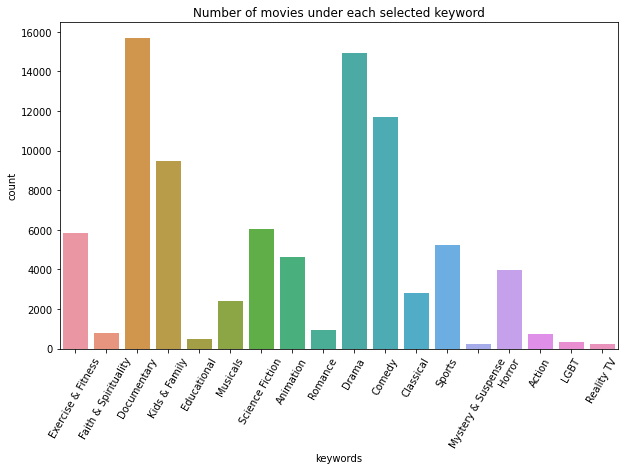

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sel_cat_df = cat_df[cat_df['category'].isin(selected_cat)]
plt.figure(figsize=(10,6))
sns.barplot(x='category', y='count', data=sel_cat_df)
plt.title('Number of movies under each selected keyword')
plt.xlabel('keywords')
plt.xticks(rotation=60)

In [ ]:
df_movie_info['extracted_categories'] = df_movie_info.apply(lambda x: re.findall(r"\b(?=("+'|'.join(selected_cat) + r")\b)", ' '.join(x['category'])), axis=1)
df_movie_info['movie_type'] = df_movie_info['extracted_categories'].map(lambda x: x[0] if x else 'other')


Text(0.5, 0, 'Movie types')

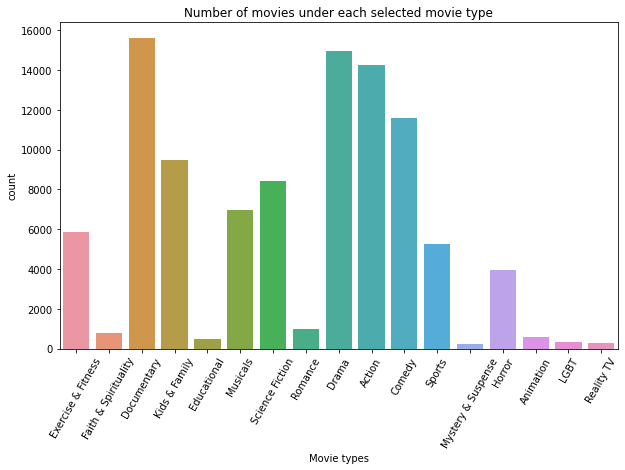

In [ ]:
df_movie_info['movie_type'].value_counts()

plt.figure(figsize=(10,6))
sns.countplot(x='movie_type', data=df_movie_info[df_movie_info['movie_type'] != 'other'])
plt.xticks(rotation=60)
plt.title('Number of movies under each selected movie type')
plt.xlabel('Movie types')

## Get Movie Rank & Price

The data type of both ranking and price information are string. Specifically, the value of column ‘rank’ is in the format of  ‘370,026 in Movies & TV’, and the value of column ‘price’ is in the format of  ‘$74.95’. In this case, we used Regex to extract the target substring and convert it into integer.

In [ ]:
df_movie_info['ranking'] = df_movie_info['rank'].str.findall(r'(?:\+|\-|\$)?\d{1,}(?:\,?\d{3})*(?:\.\d+)?%?')
df_movie_info['ranking'] = df_movie_info.apply(lambda x: int(x['ranking'][0].replace(',', '')) if type(x['ranking'])==list else None, axis=1)

In [ ]:
df_movie_info['price_cleaned'] = df_movie_info['price'].str.findall(r'\$\d+(?:\.\d+)?')
df_movie_info['price_cleaned'] = df_movie_info['price_cleaned'].map(lambda x: float(x[0][1:]) if x else None)

Besides, we found 1% of the ranking data and 40% of the price data are missing. Thus, we filled the missing data of the column ‘rank’ by the last value (ffill), and the missing data of the column ‘price’ by the mean value. .

In [ ]:
print('Propotion of missing value in ranking: ', round(sum(df_movie_info['ranking'].isnull()) / df_movie_info['ranking'].shape[0], 2))
print('Propotion of missing value in price: ', round(sum(df_movie_info['price_cleaned'].isnull()) / df_movie_info['price_cleaned'].shape[0], 2))

Propotion of missing value in ranking:  0.01
Propotion of missing value in price:  0.47


In [ ]:
df_movie_info['ranking'] = df_movie_info['ranking'].fillna(method='ffill')
df_movie_info['price_cleaned'] = df_movie_info['price_cleaned'].fillna(df_movie_info['price_cleaned'].mean())

## Get Brand

Movie Brand actually refers to the movie director or movie actors/actresses. However, there are several meaningless symbols and words in this column, like ‘*’, ‘various’, etc. Thus, we used Regex to extract the names with both capitalized first name and last name. 


In [ ]:
df_movie_info['brand_cleaned'] = df_movie_info['brand'].str.findall(r'^[a-zA-Z ]+$')
df_movie_info['brand_cleaned'] = df_movie_info['brand_cleaned'].map(lambda x: x[0] if x else None)
df_movie_info['brand_cleaned'] = df_movie_info['brand_cleaned'].map(lambda x: x if (x != 'Various')&(x != 'Learn more')&(x!='Documentary') else None)

In [ ]:
list(df_movie_info['brand'].unique())

['',
 'Alton Brown',
 'Ina Garten',
 'Joseph Prince',
 'Douglas Miller',
 'Steve Green',
 'Michael Boldea',
 'Sr. Faustina',
 'Ben Kingsley',
 'Tom Kane',
 'Jack Hayford',
 'Dr. Kent E. Hovind',
 'Vision Video',
 'Brian Barkley',
 'Brian Deacon',
 'Michael Omartian',
 'Cedarmont Kids',
 'Christopher Plummer',
 'Jonathan Winters',
 'Fred Astaire',
 'Hyun Bin',
 'Focus on the Family',
 'Learn more',
 'Jeremy Irons',
 'Tasha Mulligan',
 'Leonard Rossiter',
 'Yvonne Kong',
 'Martin Doblmeier',
 'Kurt Ewald',
 'Sedusa Instructors',
 'Wendy Stevens',
 'Erik Dalton',
 'Andy Stanley',
 'Jean-Georges Vongerichten',
 'Trevor de Kock',
 'J.T. Turner',
 'Regardt Van Den Bergh',
 'John Ankerberg / Jimmy DeYoung',
 'Neil T. Anderson',
 'Herbert von Karajan',
 'Caroll Spinney',
 'Ruthie Alcaide',
 'Jim Henson',
 'Carlo Alban',
 'Pete Townshend',
 'Paul Gilbert',
 'Tom Green (III)',
 'Michael H. King',
 '7th Grade',
 'Levi Bonilla',
 'Josh Hebner',
 'Josh Murray',
 'Dr. Danny R Faulkner',
 'Dave Stott

# Exploratory Data Analysis

## Movie Review Data

For movie review data, each record represents a user's rating for a movie, so the granularity of this data is by user by movie. We calculated the average rating and the total number of reviews for each movie. 

In [ ]:
print('Number of Unique Reviewers: ', df_movie_rating['reviewerId'].nunique())
print('Number of Unique movies:', df_movie_rating['movieId'].nunique())

Number of Unique Reviewers:  2088620
Number of Unique movies: 200941


In [ ]:
agg_review_df = df_movie_rating.groupby('movieId').agg({'rating': 'mean', 'reviewerId': 'count'}).reset_index()
agg_review_df = agg_review_df.rename(columns = {'rating': 'avg_rating', 'reviewerId': 'cnt_review'})

We can see form the distribution plot below that most movies have an average rating of greater than 3 and are mostly concentrated between 4 and 5. Thus, most of the users give ratings conservatively and will not give too low scores. Also, we found that more than 95% of the movies have less than 300 reviews and 90% of the movies have less than 40 reviews. Thus, we can conclude that most of the movie products on Amazon are long-tail products.

Text(0.5, 1.0, 'Distribution of Movie Review Counts (<90 Percentile)')

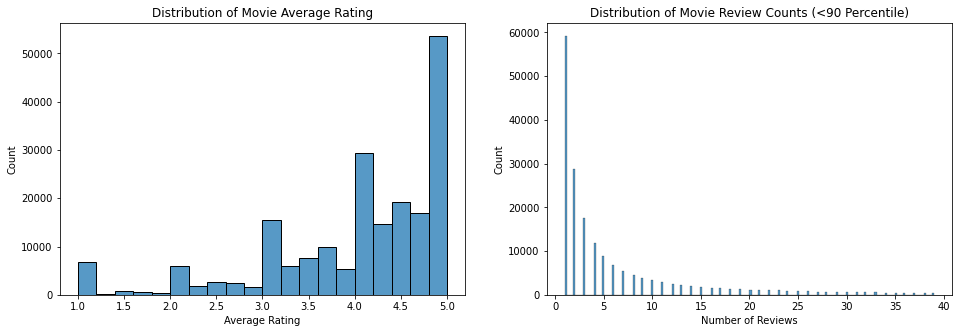

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
sns.histplot(data = agg_review_df['avg_rating'], bins = 20)
plt.xlabel('Average Rating')
plt.title('Distribution of Movie Average Rating')
plt.subplot(1,2,2)
sns.histplot(data = agg_review_df.loc[agg_review_df['cnt_review'] < 40, 'cnt_review'])
plt.xlabel('Number of Reviews')
plt.title('Distribution of Movie Review Counts (<90 Percentile)')

In [ ]:
agg_review_df['cnt_review'].describe()

count    200941.000000
mean         22.927362
std         122.403277
min           1.000000
25%           1.000000
50%           3.000000
75%          11.000000
max       11906.000000
Name: cnt_review, dtype: float64

In [ ]:
# 90% of the movies have less than 38 reviews.
agg_review_df[['cnt_review']].quantile(0.90)

cnt_review    38.0
Name: 0.9, dtype: float64

We also calculated the average rating and the total number of reviews given by each customer. There is a customer that has written more than 2,500 reviews. But 90% of the customers only gave less than 3 reviews. Thus, we think it is more worthwhile to dig into information on movie level rather than user activity, considering that we do not have other user related data on hand.


In [ ]:
agg_user_df = df_movie_rating.groupby('reviewerId').agg({'rating': 'mean', 'movieId': 'count'}).reset_index()
agg_user_df = agg_user_df.rename(columns = {'rating': 'avg_rating', 'movieId': 'cnt_review'})
agg_user_df.head()

,reviewerId,avg_rating,cnt_review
0,A00001362Q1PGIX2FYSSH,2.0,1
1,A00005181SC9PSCD58LCG,4.5,2
2,A0001392IVCRENBEIEYS,1.0,1
3,A0002090WKEMAO8KOWKM,5.0,2
4,A000222418JVUV9W33GLH,4.5,2


In [ ]:
agg_user_df['cnt_review'].describe()

count    2.088620e+06
mean     2.205785e+00
std      1.136787e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.654000e+03
Name: cnt_review, dtype: float64

In [ ]:
# 90% of the customers only gave less than 3 reviews.
agg_user_df['cnt_review'].quantile(0.9)

3.0

## Movie Info Data

In [ ]:
df_movie_info = df_movie_info[df_movie_info['movie_type'] != 'other']
print("Numebr of entries after excluding 'other': ", df_movie_info.shape[0])

Numebr of entries after excluding 'other':  99926


We explored the  two numerical features, ranking and price, in the movie data. There is no explicit explanation of the meaning of ranking, but we speculated that it represents the ordering of items within amazon. We found that there are duplicate rankings, that is, it is possible that two movies are on the same ranking. 


In [ ]:
print('Number of movies: ', df_movie_info['ranking'].shape[0])
print('Number of unique rankings: ', df_movie_info['ranking'].nunique())
print('Max ranking: ', df_movie_info['ranking'].max())
print('Min ranking: ', df_movie_info['ranking'].min())

Number of movies:  99926
Number of unique rankings:  81450
Max ranking:  19759966.0
Min ranking:  29.0


For price, we found that the prices of more than 99% of the movies are lower than \$100. The right plot below shows the distribution of movie prices that is lower than \$100. We can see that most of the movies have the price lower than \$40 and around \$20.

Text(0.5, 1.0, 'Distribution of Movie Price lower than $100')

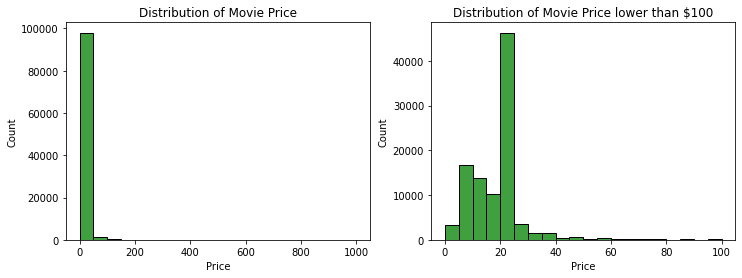

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df_movie_info['price_cleaned'], bins=20, color='g')
plt.xlabel('Price')
plt.title('Distribution of Movie Price')
plt.subplot(1,2,2)
sns.histplot(df_movie_info.loc[df_movie_info['price_cleaned'] <= 100, 'price_cleaned'], bins=20, color='g')
plt.xlabel('Price')
plt.title('Distribution of Movie Price lower than $100')

In [ ]:
df_movie_info['price_cleaned'].describe()

count    99926.000000
mean        19.326312
std         16.571571
min          0.010000
25%         12.490000
50%         20.366423
75%         20.366423
max        999.990000
Name: price_cleaned, dtype: float64

In [ ]:
df_movie_info['price_cleaned'].quantile(0.99)

78.9625

We also found the top 10 movie directors/actors/actresses that have acted in or directed the most movies for interests.

In [ ]:
type_brand_df = df_movie_info[df_movie_info['brand_cleaned']!='None'].groupby(['movie_type', 'brand_cleaned'])['asin'].count().reset_index()
type_brand_df = type_brand_df.dropna()

type_brand_df = type_brand_df.sort_values(by='asin', ascending=False)
top_10_df = type_brand_df.groupby(['movie_type']).head(10)
top_10_df.head(10)

,movie_type,brand_cleaned,asin
35610,Science Fiction,Doc Harris,107
2898,Action,LeVar Burton,96
30544,Kids & Family,Standard Deviants,77
1981,Action,Jackie Chan,68
24668,Exercise & Fitness,Leslie Sansone,60
27400,Horror,Sinister Cinema,60
30545,Kids & Family,Standard Deviants School,58
5188,Action,William Shatner,54
36398,Science Fiction,Kappei Yamaguchi,53
10175,Comedy,Stan Laurel,52


## Combine Two Data Sources

In order to investigate the relationship among average rating, review counts and movie attributes, we combined the two data tables above. 

In [ ]:
df_agg_info = df_movie_info.merge(right = agg_review_df, how = 'left', right_on = 'movieId', left_on = 'asin')

First of all, we explored the average rating distribution and review counts distribution within each movie type.

From the violin plot below, we can see that the ratings of Documentary, Kids & Family, Musicals and Faith & Spirituality movies concentrate mainly on score 5 and the ratings of Science Fiction, Romance, Drama and Action movies are distributed in all score segments. It is worth noting that the rating of horror movies are relatively lower compared to other movie types. And the ratings of LGBT movies are almost evenly distributed.


Text(0.5, 1.0, 'Distribution of average rating within each movie type')

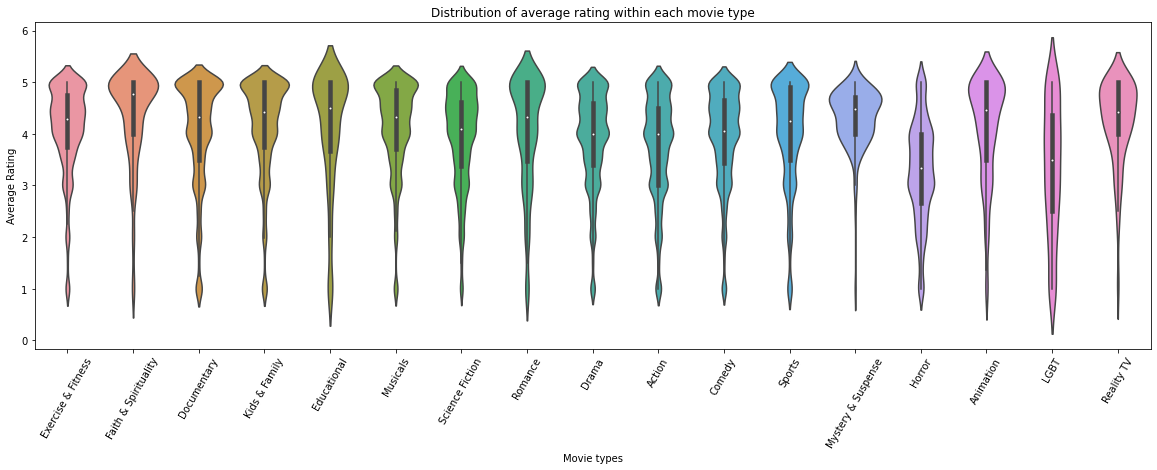

In [ ]:
plt.figure(figsize=(20,6))
sns.violinplot(x = 'movie_type', y = 'avg_rating', data = df_agg_info)
plt.xticks(rotation=60)
plt.ylabel('Average Rating')
plt.xlabel('Movie types')
plt.title('Distribution of average rating within each movie type')

Text(0.5, 1.0, 'Distribution of review counts within each movie type')

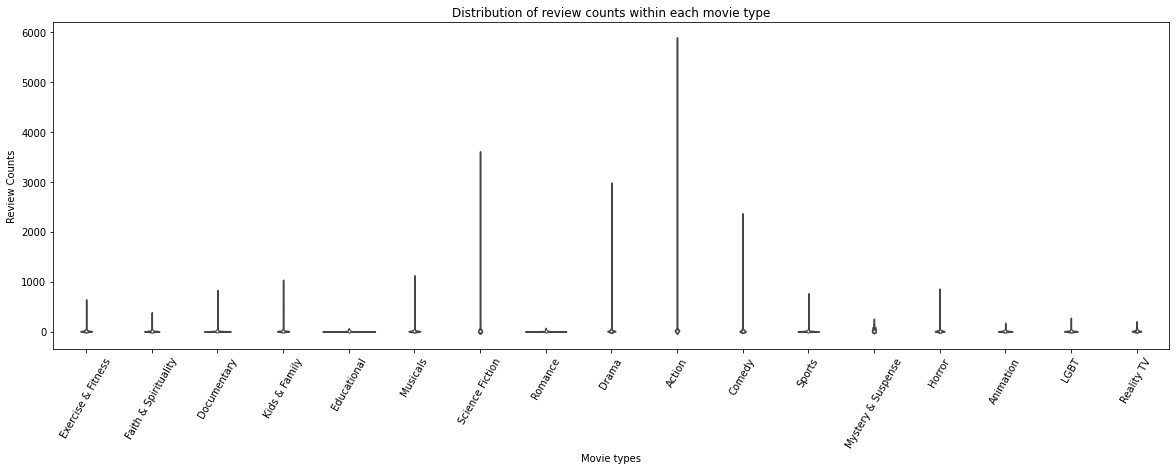

In [ ]:
plt.figure(figsize=(20,6))
sns.violinplot(x = 'movie_type', y = 'cnt_review', data = df_agg_info)
plt.xticks(rotation=60)
plt.ylabel('Review Counts')
plt.xlabel('Movie types')
plt.title('Distribution of review counts within each movie type')

We further investigate the relationships among average rating, review counts and movie attributes. We can see from the heatmap below that the average rating of a movie is negatively related to its review counts. Since most of the movies are reviewed less than 40 times, their average ratings are probably incomplete and biased to reflect the movie quality. Moreover, there is a negative correlation between review counts and rankings, that is, the more a movie is reviewed, the higher its ranking is (lower number). Thus, we can conclude that the ranking of a movie probably represents its popularity. 

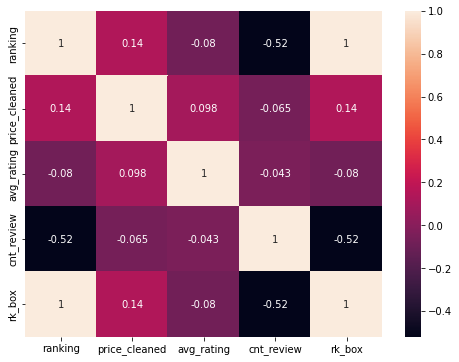

In [ ]:
df_agg_info['rk_box'] = pd.qcut(df_agg_info['ranking'], 20, labels=[i+1 for i in range(20)])
df_agg_info['rk_box'] = df_agg_info['rk_box'].astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(df_agg_info.corr(method='spearman'), annot = True)
plt.show()

In [ ]:
df_agg_info.corr()

,ranking,price_cleaned,avg_rating,cnt_review,rk_box
ranking,1.000000,0.003939,-0.123191,-0.135964,0.893050
price_cleaned,0.003939,1.000000,0.074181,-0.013432,0.004874
avg_rating,-0.123191,0.074181,1.000000,0.048511,-0.149315
cnt_review,-0.135964,-0.013432,0.048511,1.000000,-0.180379
rk_box,0.893050,0.004874,-0.149315,-0.180379,1.000000


Then we selected and rename the columns to get the final dataset that is ready to be input into the model.

In [ ]:
output_df = df_agg_info.drop(columns = ['category', 'tech1', 'description', 'fit', 'title',  'tech2', #'also_buy',
                'brand', 'feature', 'rank', 'main_cat', 'similar_item', 'date', 'price',
                'imageURL', 'imageURLHighRes', 'details', 'extracted_categories', 'movieId'])

output_df.rename(columns={'brand_cleaned': 'brand', 'price_cleaned': 'price', 'asin': 'movieId'}, inplace=True)
output_df.to_csv('../data/movie_info.csv', index=False)

In [ ]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99926 entries, 0 to 99925
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   also_buy    99926 non-null  object 
 1   also_view   99926 non-null  object 
 2   movieId     99926 non-null  object 
 3   movie_type  99926 non-null  object 
 4   ranking     99926 non-null  float64
 5   price       99926 non-null  float64
 6   brand       69233 non-null  object 
 7   avg_rating  67737 non-null  float64
 8   cnt_review  67737 non-null  float64
 9   rk_box      99926 non-null  float64
dtypes: float64(5), object(5)
memory usage: 10.4+ MB


# Data Modeling and Inferences

System overview: Our recommendation system was built in two ways. The first model was accomplished by an unsupervised clustering model, while the second revised model was implemented by collaborative filtering method. We used the KMeans model to cluster customers' movie rating matrix, and then voted the clustering labels based on customers' historical browsing data and recommended the whole corresponding cluster of movies. We also used item-based collaborative filtering to make small-scale movie recommendations to customers.


In [ ]:
movie_df = pd.read_csv('../data/movie_info.csv')
# rating_df = pd.read_csv('selected_df_newest.csv')
rating_df = pd.read_csv('../data/ratings_Movies_and_TV.csv', header = None)
# rating_df = pd.read_hdf('../data/ratings_Movies_and_TV.h5','df')
rating_df.rename({0: 'reviewerId', 1: 'movieId', 2: 'rating', 3: 'reviewTime'}, axis = 1, inplace = True)
movie_df.head()

,also_buy,also_view,movieId,movie_type,ranking,price,brand,avg_rating,cnt_review,rk_box
0,[],[],000073991X,Exercise & Fitness,444474.0,20.366423,Joseph Prince,NaN,NaN,16.0
1,[],[],0001499572,Faith & Spirituality,806803.0,20.366423,NaN,NaN,NaN,19.0
2,[],[],0001421409,Faith & Spirituality,722400.0,20.366423,Michael Boldea,NaN,NaN,19.0
3,['B000EK77AM'],[],0001517791,Exercise & Fitness,439066.0,20.366423,NaN,5.0,2.0,16.0
4,[],[],0001485423,Documentary,346429.0,20.366423,NaN,5.0,1.0,14.0


## Remove Outlier

Even after the data cleaning, we still faced a large sparse dataset. However, due the amount of data is too large to be processed by Google Colab, we decided to select part of the data for modeling and analysis. In the original dataset, there are  4,607,047  reviews, 2,088,620  reviewers and  200,941 movies. Our subsequent modeling and analysis would only focus on those movies that have been watched more than 500 times and those customers who have seen at least 10 or more movies. As a result, there are 167,833 reviews, 7,614 customers and 1,278 movies in the remaining selected dataset.


In [ ]:
def remove_outlier(df, m, n, save = False):
    
    review_ct = df.shape[0]
    reviewer_ct = df['reviewerId'].nunique()
    moviect = df.groupby('movieId')[['reviewerId']].count().reset_index()
    movie_ct = moviect.shape[0]
    sel_moviect = moviect[moviect['reviewerId'] >= m]
    sel_movie_ct = sel_moviect.shape[0]
    sel_df = df[df['movieId'].isin(sel_moviect['movieId'])]
    sel_review_ct = sel_df.shape[0]
    
    userct = sel_df.groupby('reviewerId')[['movieId']].count().reset_index()
    user_ct = userct.shape[0]
    sel_userct = userct[userct['movieId'] >= n]
    sel_user_ct = sel_userct.shape[0]
    selected_df = sel_df[sel_df['reviewerId'].isin(sel_userct['reviewerId'])]
    selected_review_ct = selected_df.shape[0]

    print('There are ', review_ct, ' reviews,', reviewer_ct, ' reviewers, and ', movie_ct, 'movies in the raw data.')
    print('+---------------------------------------------+')
    print('If we only focus on movies with ', m, ' or more reviews, ')
    print('The number of movies will decrease from ', movie_ct, ' to ', sel_movie_ct)
    print('+---------------------------------------------+')
    print('If we only focus on reviewers who reviewed ', n, ' or more movies, ')
    print('The number of reviewers will decrease from ', user_ct, ' to ', sel_user_ct)
    print('+---------------------------------------------+')
    print('The number of reviews will decrease to ', selected_review_ct)
    if save:
        selected_df.to_csv('../data/selected_df_{}.csv'.format(m))
    return selected_df

In [ ]:
selected_rating_df = remove_outlier(rating_df, m = 500, n = 10, save=True)

There are  4607047  reviews, 2088620  reviewers, and  200941 movies in the raw data.
+---------------------------------------------+
If we only focus on movies with  500  or more reviews, 
The number of movies will decrease from  200941  to  1278
+---------------------------------------------+
If we only focus on reviewers who reviewed  10  or more movies, 
The number of reviewers will decrease from  858414  to  7614
+---------------------------------------------+
The number of reviews will decrease to  167833


## Define Metrics

To measure the performance of models, we used multiple metrics including precision, recall and detection rate. We used recall and precision to measure the performance from items. perspective, and used detection from users' perspective.

In [ ]:

def Recall(Rec_dict, Val_dict):
    '''indicates how many of the actual bought movies are correctly recommended
    Args:
        Rec_dict (dict): list of recommendation for each customer, in shape of {uid: {item1, item2,...}, uid: {item1, item2,...}, ...} 
        Val_dict (dict): list of movies actually bought by each customer, in shape of {uid: {item1, item2,...}, uid: {item1, item2,...}, ...}
    '''
    hit_items = 0
    all_items = 0
    for uid, items in Val_dict.items():
        rel_set = items
        rec_set = Rec_dict[uid]
        for item in rec_set:
            if item in rel_set:
                hit_items += 1
        all_items += len(rel_set)

    return round(hit_items / all_items * 100, 2)

def Precision(Rec_dict, Val_dict):
    '''indicates that how many of our recommended movies are actually bought by the customer
    Args:
        Rec_dict (dict): list of recommendation for each customer, in shape of {uid: {item1, item2,...}, uid: {item1, item2,...}, ...} 
        Val_dict (dict): list of movies actually bought by each customer, in shape of {uid: {item1, item2,...}, uid: {item1, item2,...}, ...}
    '''
    hit_items = 0
    all_items = 0
    for uid, items in Val_dict.items():
        rel_set = items
        rec_set = Rec_dict[uid]

        for item in rec_set:
            if item in rel_set:
                hit_items += 1
        all_items += len(rec_set)

    return round(hit_items / all_items * 100, 2)
  
def Detection(Rec_dict, Val_dict):
    '''indicates that how many of the customers received one or more correct recommendation
    Args:
        Rec_dict (dict): list of recommendation for each customer, in shape of {uid: {item1, item2,...}, uid: {item1, item2,...}, ...} 
        Val_dict (dict): list of movies actually bought by each customer, in shape of {uid: {item1, item2,...}, uid: {item1, item2,...}, ...}
    '''
    hit_users = 0
    all_users = len(Val_dict)
    non_rec = 0
    for uid, items in Val_dict.items():
        rel_set = items
        rec_set = Rec_dict[uid]
        if len(rec_set) < 1:
            non_rec += 1
        for item in rec_set:
            if item in rel_set:
                hit_users += 1
                break
    all_users = all_users - non_rec
    return round(hit_users / all_users * 100, 2)

## Movie Clustering

Clustering is to group data objects into multiple clusters. Its goal is to have high similarity among objects in the same cluster, while objects in different clusters differ greatly. In this case, we assumed that customers would like similar movies, so we used the KMeans model to cluster the movies and then recommended similar movies to customers.

### By Moive Attributes

We first clustered the movie with 4 clusters on `price`, `avg_rating`, `cnt_review` and `rk_box` attributes from the cleaned `movie_info` table. 

In [ ]:
print("Number of entries before selection: ", movie_df.shape[0])
movie_df_selected = movie_df[movie_df['movieId'].isin(selected_rating_df['movieId'].unique())].reset_index(drop=True)
print("Number of entries after selection: ", movie_df_selected.shape[0])

# print("Number of entries before selection: ", df_movie_info.shape[0])
# movie_df_selected = df_movie_info[df_movie_info['asin'].isin(rating_df['movieId'].unique())].reset_index(drop=True)
# print("Number of entries after selection: ", movie_df_selected.shape[0])

Number of entries before selection:  99926
Number of entries after selection:  288


In [ ]:
# movie_df_selected['price'] = movie_df_selected['price'].fillna(method='ffill')
# movie_df_selected['avg_rating'] = movie_df_selected['avg_rating'].fillna(method='ffill')
# movie_df_selected['rk_box'] = movie_df_selected['rk_box'].fillna(method='ffill')
movie_df_selected['price'] = movie_df_selected['price'].fillna(movie_df_selected['price'].mean())
movie_df_selected['avg_rating'] = movie_df_selected['avg_rating'].fillna(movie_df_selected['avg_rating'].mean())
movie_df_selected['rk_box'] = movie_df_selected['rk_box'].fillna(movie_df_selected['rk_box'].mean())

We used KMeans model to cluster movies into 4 cluster and showed the number of movies in each cluster.

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

cluster_input = movie_df_selected[['price', 'avg_rating', 'cnt_review', 'rk_box']]
scaler = StandardScaler()
cluster_input = pd.DataFrame(scaler.fit_transform(cluster_input), columns=cluster_input.columns)

kmeans = KMeans(n_clusters=4, random_state=0).fit(cluster_input)
cluster_input['class'] = kmeans.labels_
print('The number of movies in each cluster:')
print(cluster_input['class'].value_counts())

The number of movies in each cluster:
0    136
1     98
2     43
3     11
Name: class, dtype: int64


We used PCA dimensionality reduction to extract the three most representative dimensions and then we visualized the clustering results in the 3D plot.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
decomposition_data_1 = pca.fit_transform(cluster_input.drop(columns=['class']))

decomposition_data_1 = pd.DataFrame(decomposition_data_1, columns=['x', 'y', 'z'])
decomposition_data_1['class'] = cluster_input['class'].reset_index(drop=True).astype(str)

In [ ]:
import plotly.express as px
fig = px.scatter_3d(decomposition_data_1, x='x', y='y', z='z', color = 'class')
fig.update_traces(marker_size = 4)
fig.show()

### By Review Activity

At the same time, we reconstructed the rows and columns of the customers' movie rating table, and obtained a table with rows of `movieId`, columns of `customerId` and corresponding values of the customer's rating of the movie.

In [ ]:
two_level_index_series = selected_rating_df.set_index(['reviewerId', 'movieId'])['rating']
cluster_input_2 = two_level_index_series.unstack()
cluster_input_2 = cluster_input_2.fillna(0).T
cluster_input_2.head()

reviewerId,A0882267H0AW4UOUDXH9,A100JCBNALJFAW,A100RW34WSLTUW,A100WFKYVRPVX7,A10175AMUHOQC4,A102B8D74H64TO,A102RDJLOHWS0W,A103EXN5Q7HX6Z,A103KNDW8GN92L,A1041053SID37WN8GTT8,...,AZVEPWRYOFBX5,AZVRFM578CX6M,AZWIQDC9S1KEM,AZXGPM8EKSHE9,AZXP46IB63PU8,AZY093IX3TILG,AZYGRG27CDIA3,AZYJ9TS07B02W,AZZ4GD20C58ND,AZZFRAVW4CR5I
movieId,,,,,,,,,,,,,,,,,,,,,
0310263662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
0310274281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0767002652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0767726227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
076780192X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our second clustering method will cluster the movies according to customers' ratings of the movies. In this case, the granularity of the data is the movie, and each customers' rating to the movie is taken as a feature.

In [ ]:
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters=5, random_state=56)
kmeans2.fit(cluster_input_2)
cluster_input_2['class'] = kmeans2.labels_
print('The number of movies in each cluster:')
cluster_input_2['class'].value_counts()

The number of movies in each cluster:


4    744
0    215
1    189
2    128
3      1
Name: class, dtype: int64

We used PCA dimensionality reduction to extract the three most representative dimensions of the two matrices respectively, and then we visualized and compared the results of the two clustering approaches in the 3D plots=. We found that the second clustering method performed better. As a result, we would vote the clustering labels based on customers' historical browsing data and recommend the whole corresponding cluster of movies based on the second clustering result. 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
decomposition_data = pca.fit_transform(cluster_input_2.drop(columns=['class']))

decomposition_data = pd.DataFrame(decomposition_data, columns=['x', 'y', 'z'])
decomposition_data['class'] = cluster_input_2['class'].reset_index(drop=True).astype(str)

In [ ]:
import plotly.express as px
fig = px.scatter_3d(decomposition_data, x='x', y='y', z='z', color = 'class')
fig.update_traces(marker_size = 4)
fig.show()

## Split Dataset

Before modeling, the dataset was divided into a training set and a test set. In order to simulate the use of historical data to predict the future in the real forecasting scenarios, we should keep those events that occur after the events used to fit the model as the test set. Therefore, we sorted the customer ratings' table by the timestamp of the reviews, and then splitted the training set and test set in that chronological order.

In [ ]:
def data_processing(df):

    df = df.sort_values(by = 'reviewTime')
    X_train, X_test, _, _ = train_test_split(df, df, shuffle = False, test_size=0.2)

    # df[reviewer] reviewer_1 -> df['movieId'] [movie_a, movie_d, movie_f, movie_q, movie_h]
    X_train = X_train.groupby('reviewerId')['movieId'].apply(list).reset_index()
    X_train = X_train[X_train['movieId'].str.len() >= 2]

    X_test = X_test.groupby('reviewerId')['movieId'].apply(list).reset_index()
    X_test = X_test[X_test['movieId'].str.len() >= 2]

    train_reviewer_items = {}
    test_reviewer_items = {}

    # train_reviewer_items records the movieIds that the user has actually reviewed in training set
    for reviewer, movies in zip(*(list(X_train['reviewerId']), list(X_train['movieId']))):
        train_reviewer_items[reviewer] = set(movies)
    # test_reviewer_items records the movieIds that the user has actually reviewed in testing set
    for reviewer, movies in zip(*(list(X_test['reviewerId']), list(X_test['movieId']))):
        test_reviewer_items[reviewer] = set(movies)
    
    return X_train, X_test, train_reviewer_items, test_reviewer_items

In [ ]:
X_train, X_test, train_reviewer_items, test_reviewer_items = data_processing(selected_rating_df)

## Reccomendation Model

### Baseline

In the `movie_info` table, column `also_buy` represents other movies purchased by users who purchased that movie. Our baseline model assumes that customers who have purchased this movie will also like other movies purchased by other people who have purchased this movie. Then, the baseline model would find the `also_buy` movies and recommend them based on the historical customers' reviewing data. This baseline model is naive but we would compare the recommended results of the other two models with the baseline to prove whether our model is effective or not.

In [ ]:
movie_df['also_buy_cleaned'] = movie_df['also_buy'].str.findall(r'\'(.*?)\'')

In [ ]:
movie_df['also_buy_cleaned'].str.len().value_counts()

0     49117
1      6899
2      4180
3      2954
4      2374
      ...  
70       96
81       94
71       90
82       89
76       82
Name: also_buy_cleaned, Length: 101, dtype: int64

In [ ]:
also_buy = defaultdict(set)
for movie, alsobuy in zip(*(list(movie_df['movieId']), list(movie_df['also_buy_cleaned']))):
        also_buy[movie] = set(alsobuy)

# for movie, alsobuy in zip(*(list(df_movie_info['asin']), list(df_movie_info['also_view']))):
#         also_buy[movie].update(set(alsobuy))

In [ ]:
items_baseline = {}
print('Recommending．．．')
for uid, _ in tqdm(test_reviewer_items.items()):
    # Store recommended candidates for customer
    items_baseline[uid] = set()
    if uid not in train_reviewer_items.keys():
        continue
    # Run through the customer's historical favorite items to find similar items below
    for hist_item in train_reviewer_items[uid]:
        if len(items_baseline[uid]) > 5: continue
        items_baseline[uid].update(also_buy[hist_item])
        if len(items_baseline[uid]) > 5: 
          items_baseline[uid] = set(list(items_baseline[uid])[:5])

Recommending．．．


100%|██████████| 3732/3732 [00:00<00:00, 20420.49it/s]


In [ ]:
print('Recall:', Recall(items_baseline, test_reviewer_items), '%')
print('Precision', Precision(items_baseline, test_reviewer_items), '%')
print('Detection', Detection(items_baseline, test_reviewer_items), '%')

Recall: 0.06 %
Precision 0.19 %
Detection 0.92 %


### Recommend by Movie Cluster

Based on the clustering result, we would vote the clustering labels based on customers' historical browsing data and recommend the whole corresponding cluster of movies. 

In [ ]:
movie_class_df = cluster_input_2['class'].reset_index()
movie_class = dict(zip(movie_class_df['movieId'], movie_class_df['class']))

class_movie = defaultdict(set)
class_movie[999] = set()
for movie, CLASS in zip(movie_class_df['movieId'], movie_class_df['class']):
        class_movie[CLASS].add(movie)

In [ ]:
items_class = defaultdict(int)
print('Recommending．．．')
for uid, _ in tqdm(test_reviewer_items.items()):
    # Store recommended candidates for customer
    items_class[uid] = defaultdict(int) 
    if uid not in train_reviewer_items.keys():
        continue
    # Run through the customer's historical favorite items to find similar items below
    for hist_item in train_reviewer_items[uid]: 
        items_class[uid][movie_class[hist_item]] += 1
  
items_class = {k: max(v,key=v.get) if v else 999 for k, v in items_class.items()}
items_class = {k: class_movie[v] for k, v in items_class.items()}


Recommending．．．


100%|██████████| 3732/3732 [00:00<00:00, 98586.95it/s]


In [ ]:
print('Recall:', Recall(items_class, test_reviewer_items), '%')
print('Precision', Precision(items_class, test_reviewer_items), '%')
print('Detection', Detection(items_class, test_reviewer_items), '%')

Recall: 35.47 %
Precision 0.92 %
Detection 85.07 %


### ItemCF

Collaborative Filtering (CF) is rapidly becoming a popular technology in information filtering systems. We chose to use item based CF which assumes that similar items are likely to be liked by the same user. In other words, items liked by the same user are similar items. For example, movie 1 and movie 2, both of which are liked by customer A, are similar. Movies 5 and 6, however, are not liked by the same customers at the same time, so they are not similar. 

#### Co-occurrence Matrix

In order to build this model, we first counted the number of times that each movie was liked by customers and the number of times that each movie was liked by multiple customers at the same time by using the hash dictionary. For example, suppose there are five customers A, B, C, D, and E. Customer A likes movies a, b, and c, and customer B likes movies a, b, and so on. Movie a and movie b are favored by customer A, B and C at the same time, so the co-occurrence times of movie a  and movie b are 3. This statistical method could be used to quickly construct the co-occurrence matrix. 

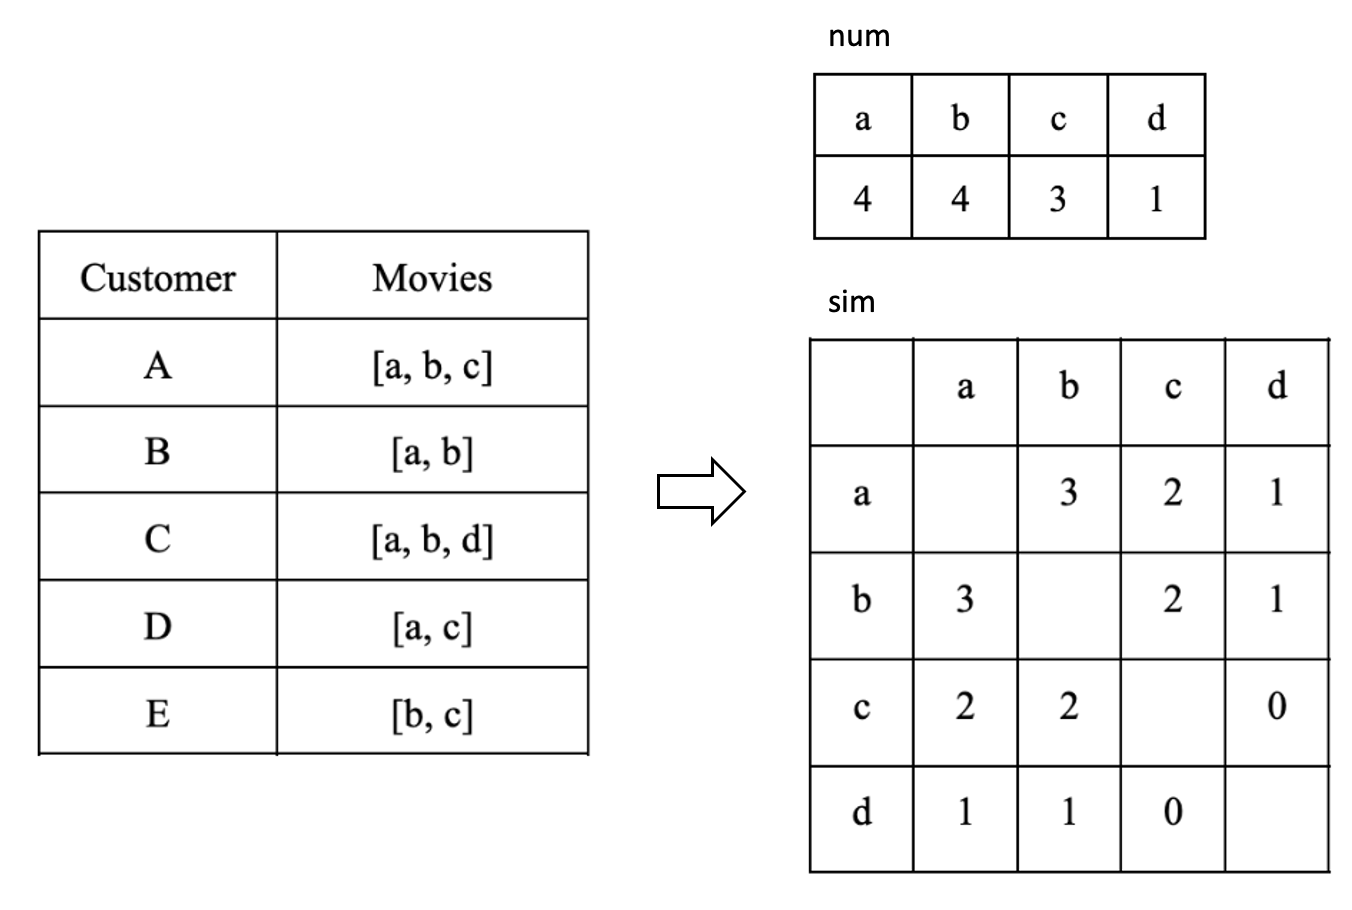

In [ ]:
# Co-occurrence Matrix
sim = defaultdict(int)
# Review Count Matrix
num = defaultdict(int)

for uid, items in tqdm(train_reviewer_items.items()):
    # For each movie in the list of movies reviewed by the current user
    for i in items:
        # Count the number of times movie i is reivewed
        num[i] += 1
        # Count the co-occurrence times of movie i and movie j
        if i not in sim:
            sim[i] = defaultdict(int)
        for j in items:
            if i != j:
                sim[i][j] += 1

100%|██████████| 6964/6964 [00:02<00:00, 2399.05it/s]


#### Similarity Matrix

The next step was to calculate the similarity among each movie. The formula is shown below.
 
$$W_{uv}=\frac{|N(u)||N(v)|}{\sqrt{|N(u)||N(v)|}}$$

*N(u)* represents the number of customers who like the movie *u*, *N(v)* represents the number of customers who like the movie *v*, and the intersection of the two represents the number of customers who like both movie *u* and *v*, that is the value in co-occurrence matrix. 

In [ ]:
# Similarity Matrix
for i, items in tqdm(sim.items()):
    for j, score in items.items():
        if i != j:
           sim[i][j] = score / math.sqrt(num[i] * num[j])

100%|██████████| 1220/1220 [00:00<00:00, 1638.22it/s]


Therefore, based on the similarity matrix calculated above, we could sort the similarity and recommend top-n movies to customers.

In [ ]:
items_rank = defaultdict(int)
print('Recommending．．．')
for uid, _ in tqdm(test_reviewer_items.items()):
    # Store recommended candidates for customer
    items_rank[uid] = defaultdict(int)
    if uid not in train_reviewer_items.keys():
        continue
    # Run through the customer's historical favorite items to find similar items below
    for hist_item in train_reviewer_items[uid]:
        for item, score in sorted(sim[hist_item].items(), key=lambda x: x[1], reverse=True)[:80]:
            # Recommended items should not appear in historical favorites
            if item not in train_reviewer_items[uid]:
                # Calculate the similarity score of the current item by the current uid
                items_rank[uid][item] += score
    
print('Recommend Top - 10 movies with the highest similarity score for each customers...')
items_rank = {k: sorted(v.items(), key=lambda x: x[1], reverse=True)[:10] for k, v in items_rank.items()}
items_rank = {k: set([x[0] for x in v]) for k, v in items_rank.items()}

Recommending．．．


100%|██████████| 3732/3732 [00:14<00:00, 249.59it/s]


Recommend Top - 10 movies with the highest similarity score for each customers...


In [ ]:
print('Recall:', Recall(items_rank, test_reviewer_items), '%')
print('Precision', Precision(items_rank, test_reviewer_items), '%')
print('Detection', Detection(items_rank, test_reviewer_items), '%')

Recall: 2.17 %
Precision 2.32 %
Detection 16.87 %
